# Análises Intermediárias - Dados Bancários

Este notebook contém **3 consultas intermediárias** utilizando JOINs para análise aprofundada dos dados bancários.

## Objetivo
- Correlacionar dados entre tabelas
- Identificar padrões de comportamento dos clientes
- Analisar performance por agência e região
- Obter insights de relacionamento entre entidades

In [ ]:
# Configuração inicial
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sqlalchemy import create_engine, text
from datetime import datetime, timedelta
import warnings, os
from dotenv import load_dotenv 
 
# Carregar variáveis do arquivo .env de um diretório específico
env_path = "../env_files/.env"
load_dotenv(dotenv_path=env_path)
warnings.filterwarnings('ignore')

# Database configuration - Alinhado com notebooks 01-03
DB_CONFIG = {
    'host': os.getenv("PGHOST", "localhost"),
    'port': int(os.getenv("PGPORT", "5432")),  # Converter para int
    'user': os.getenv("PGUSER", "postgres"),
    'password': os.getenv("PGPASSWORD", "postgres"),
    'database': os.getenv("PGDATABASE", "mkl_bank"),  # Target database correto
    'sslmode': os.getenv("PGSSLMODE", "require"),
    'connect_timeout': 30,
    'application_name': 'MKL-Bank-Analytics-Intermediate'
}

# Criar conexão
connection_string = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}?sslmode={DB_CONFIG['sslmode']}&connect_timeout={DB_CONFIG['connect_timeout']}&application_name={DB_CONFIG['application_name']}"
engine = create_engine(connection_string)

# Schema alvo correto
TARGET_SCHEMA = os.getenv("TARGETSCHEMA", "core_bank")  # Schema correto

# Configurar estilo dos gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Configuração concluída!")
print(f"🔗 Conectado ao banco: {DB_CONFIG['database']}")
print(f"📊 Schema: {TARGET_SCHEMA}")

✅ Configuração concluída!
🔗 Conectado ao banco: fsi_db
📊 Schema: mkl_bank


## 🏦 Consulta 1: Performance de Movimentações por Agência

**Objetivo**: Analisar o volume de transações e valores movimentados por cada agência, identificando as mais ativas.

In [ ]:
# Vamos verificar a estrutura das tabelas principais para usar os nomes corretos
tables_to_check = ['agencias', 'clientes', 'contas', 'cartoes', 'chaves_pix']

for table in tables_to_check:
    print(f"\n🔍 ESTRUTURA DA TABELA {table.upper()}")
    print("=" * 50)
    
    query_estrutura = f"""
    SELECT column_name, data_type 
    FROM information_schema.columns 
    WHERE table_schema = '{TARGET_SCHEMA}' 
    AND table_name = '{table}'
    ORDER BY ordinal_position;
    """
    
    estrutura = pd.read_sql(query_estrutura, engine)
    for _, row in estrutura.iterrows():
        print(f"{row['column_name']:<25}: {row['data_type']}")

print("\n✅ Estruturas verificadas - agora vamos ajustar as consultas!")


🔍 ESTRUTURA DA TABELA AGENCIA
codigo_agencia           : character varying
nome                     : character varying
endereco                 : character varying
cidade                   : character varying
estado                   : character
telefone                 : character varying

🔍 ESTRUTURA DA TABELA CLIENTE
id_cliente               : integer
cpf                      : character varying
nome                     : character varying
data_nascimento          : date
genero                   : character
email                    : character varying
telefone                 : character varying

🔍 ESTRUTURA DA TABELA CONTA
id_conta                 : integer
id_conta             : character varying
codigo_agencia           : character varying
id_cliente               : integer
saldo                    : numeric
data_abertura            : date
status                   : character

🔍 ESTRUTURA DA TABELA CARTAO
numero_cartao            : text
id_cliente               : bigint
data_em

In [ ]:
# Consulta 1: Performance de movimentações por agência
query_1 = f"""
SELECT 
    a.codigo_agencia,
    a.nome as nome_agencia,
    a.cidade,
    a.estado,
    COUNT(t.id_transacao) as total_transacoes,
    SUM(t.valor) as valor_total_movimentado,
    AVG(t.valor) as valor_medio_transacao,
    COUNT(DISTINCT c.id_conta) as contas_ativas,
    COUNT(DISTINCT cl.id_cliente) as clientes_unicos
FROM "{TARGET_SCHEMA}".agencias a
LEFT JOIN "{TARGET_SCHEMA}".contas c ON a.codigo_agencia = c.codigo_agencia
LEFT JOIN "{TARGET_SCHEMA}".clientes cl ON c.id_cliente = cl.id_cliente
LEFT JOIN "{TARGET_SCHEMA}".transacoes t ON c.id_conta = t.id_conta
GROUP BY a.codigo_agencia, a.nome, a.cidade, a.estado
HAVING COUNT(t.id_transacao) > 0
ORDER BY valor_total_movimentado DESC
LIMIT 15;
"""

resultado_1 = pd.read_sql(query_1, engine)

print("🏦 TOP 15 AGÊNCIAS POR MOVIMENTAÇÃO FINANCEIRA")
print("=" * 80)
print(f"{'Agência':<8} {'Cidade':<15} {'UF':<3} {'Transações':<10} {'Valor Total':<15} {'Valor Médio':<12}")
print("-" * 80)

for _, row in resultado_1.head(10).iterrows():
    print(f"{row['codigo_agencia']:<8} {row['cidade'][:14]:<15} {row['estado']:<3} "
          f"{row['total_transacoes']:>8,} {row['valor_total_movimentado']:>14,.0f} "
          f"{row['valor_medio_transacao']:>11,.0f}")

# Visualização interativa com Plotly
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Volume de Transações por Agência',
        'Valor Total Movimentado por Agência', 
        'Distribuição por Estado',
        'Relação: Transações vs Valor Médio'
    ),
    specs=[[{"type": "bar"}, {"type": "bar"}],
           [{"type": "pie"}, {"type": "scatter"}]]
)

# Gráfico 1: Volume de transações
fig.add_trace(
    go.Bar(
        x=resultado_1.head(10)['codigo_agencia'],
        y=resultado_1.head(10)['total_transacoes'],
        name='Transações',
        text=resultado_1.head(10)['total_transacoes'],
        textposition='auto',
        marker_color='lightblue'
    ),
    row=1, col=1
)

# Gráfico 2: Valor total
fig.add_trace(
    go.Bar(
        x=resultado_1.head(10)['codigo_agencia'],
        y=resultado_1.head(10)['valor_total_movimentado'],
        name='Valor Total',
        text=[f'R$ {x/1e6:.1f}M' for x in resultado_1.head(10)['valor_total_movimentado']],
        textposition='auto',
        marker_color='lightgreen'
    ),
    row=1, col=2
)

# Gráfico 3: Distribuição por estado
estado_dist = resultado_1.groupby('estado')['total_transacoes'].sum().reset_index()
fig.add_trace(
    go.Pie(
        labels=estado_dist['estado'],
        values=estado_dist['total_transacoes'],
        name='Estados'
    ),
    row=2, col=1
)

# Gráfico 4: Scatter plot
fig.add_trace(
    go.Scatter(
        x=resultado_1['total_transacoes'],
        y=resultado_1['valor_medio_transacao'],
        mode='markers',
        text=resultado_1['codigo_agencia'],
        name='Agências',
        marker=dict(size=10, color='red', opacity=0.7)
    ),
    row=2, col=2
)

fig.update_layout(height=800, showlegend=False, title_text="Análise de Performance por Agência")
fig.show()

print(f"\n📈 Resumo:")
print(f"• Agência mais ativa: {resultado_1.iloc[0]['nome_agencia']} ({resultado_1.iloc[0]['codigo_agencia']})")
print(f"• Total movimentado: R$ {resultado_1.iloc[0]['valor_total_movimentado']:,.2f}")
print(f"• Estados com mais transações: {', '.join(estado_dist.head(3)['estado'].tolist())}")

🏦 TOP 15 AGÊNCIAS POR MOVIMENTAÇÃO FINANCEIRA
Agência  Cidade          UF  Transações Valor Total     Valor Médio 
--------------------------------------------------------------------------------
2199     Vieira          PB       884     44,311,500      50,126
5981     Rocha Paulista  SP       865     44,306,984      51,222
4522     Rocha           RS       847     43,828,853      51,746
7273     Marques         RJ       853     41,367,499      48,496
4415     Sampaio de da   RN       794     41,013,084      51,654
5430     Casa Grande     SP       833     41,000,954      49,221
1257     Camargo Grande  MT       806     39,931,941      49,543
1714     Rocha           PB       777     39,801,029      51,224
6187     da Rocha de So  AP       765     39,515,033      51,654
8316     Pinto           RJ       773     38,178,365      49,390



📈 Resumo:
• Agência mais ativa: Agência 2199 (2199)
• Total movimentado: R$ 44,311,500.16
• Estados com mais transações: AP, CE, MT


## 👥 Consulta 2: Perfil de Clientes por Tipo de Movimentação

**Objetivo**: Analisar o comportamento dos clientes segmentados por tipos de transação e produtos utilizados.

👥 PERFIL DE CLIENTES POR SEGMENTO E FAIXA ETÁRIA
Segmento   Faixa Etária    Qtd    Mov.Média    Cartões  PIX   
------------------------------------------------------------------------------------------
Premium    Adulto (25-40)   210   5,145,209     4.1   0.9
Premium    Jovem (< 25)     113   5,293,526     4.3   0.8
Premium    Maduro (40-60)   316   5,249,553     4.2   0.9
Premium    Senior (60+)     351   5,237,933     4.4   0.9
Gold       Adulto (25-40)     2     353,227     1.0   0.0
Gold       Jovem (< 25)       3     391,452     1.0   0.3
Gold       Maduro (40-60)     1     177,023     0.0   0.0
Gold       Senior (60+)       4     380,969     0.8   0.5


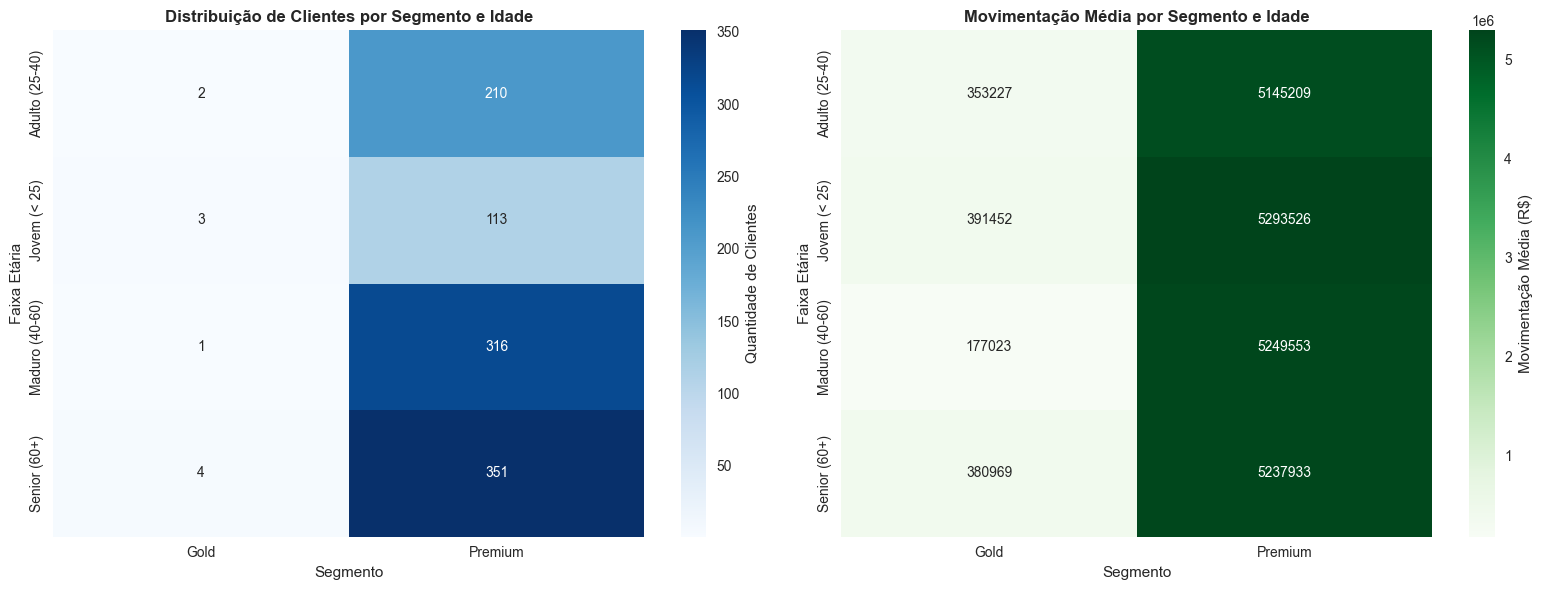


💼 Resumo por Segmento:
• Gold: 10 clientes, 0.1% do volume total
• Premium: 990 clientes, 99.9% do volume total


In [ ]:
# Consulta 2: Perfil de clientes por tipo de movimentação
query_2 = f"""
WITH cliente_perfil AS (
    SELECT 
        cl.id_cliente,
        cl.nome as nome_cliente,
        cl.cpf,
        EXTRACT(YEAR FROM CURRENT_DATE) - EXTRACT(YEAR FROM cl.data_nascimento) as idade,
        COUNT(DISTINCT c.id_conta) as total_contas,
        COUNT(DISTINCT cart.numero_cartao) as total_cartoes,
        COUNT(DISTINCT pix.id_chave_pix) as total_chaves_pix,
        COUNT(t.id_transacao) as total_transacoes,
        SUM(t.valor) as valor_total_movimentado,
        AVG(t.valor) as valor_medio_transacao
    FROM "{TARGET_SCHEMA}".clientes cl
    LEFT JOIN "{TARGET_SCHEMA}".contas c ON cl.id_cliente = c.id_cliente
    LEFT JOIN "{TARGET_SCHEMA}".cartoes cart ON cl.id_cliente = cart.id_cliente
    LEFT JOIN "{TARGET_SCHEMA}".chaves_pix pix ON c.id_conta = pix.id_conta
    LEFT JOIN "{TARGET_SCHEMA}".transacoes t ON c.id_conta = t.id_conta
    GROUP BY cl.id_cliente, cl.nome, cl.cpf, cl.data_nascimento
),
segmentacao AS (
    SELECT *,
        CASE 
            WHEN valor_total_movimentado >= 500000 THEN 'Premium'
            WHEN valor_total_movimentado >= 100000 THEN 'Gold'
            WHEN valor_total_movimentado >= 50000 THEN 'Silver'
            ELSE 'Standard'
        END as segmento_cliente,
        CASE 
            WHEN idade < 25 THEN 'Jovem (< 25)'
            WHEN idade < 40 THEN 'Adulto (25-40)'
            WHEN idade < 60 THEN 'Maduro (40-60)'
            ELSE 'Senior (60+)'
        END as faixa_etaria
    FROM cliente_perfil
    WHERE total_transacoes > 0
)
SELECT 
    segmento_cliente,
    faixa_etaria,
    COUNT(*) as quantidade_clientes,
    AVG(total_transacoes) as media_transacoes,
    AVG(valor_total_movimentado) as media_movimentacao,
    AVG(total_cartoes) as media_cartoes,
    AVG(total_chaves_pix) as media_chaves_pix,
    SUM(valor_total_movimentado) as valor_total_segmento
FROM segmentacao
GROUP BY segmento_cliente, faixa_etaria
ORDER BY 
    CASE segmento_cliente 
        WHEN 'Premium' THEN 1 
        WHEN 'Gold' THEN 2 
        WHEN 'Silver' THEN 3 
        ELSE 4 
    END,
    faixa_etaria;
"""

resultado_2 = pd.read_sql(query_2, engine)

print("👥 PERFIL DE CLIENTES POR SEGMENTO E FAIXA ETÁRIA")
print("=" * 90)
print(f"{'Segmento':<10} {'Faixa Etária':<15} {'Qtd':<6} {'Mov.Média':<12} {'Cartões':<8} {'PIX':<6}")
print("-" * 90)

for _, row in resultado_2.iterrows():
    print(f"{row['segmento_cliente']:<10} {row['faixa_etaria']:<15} "
          f"{row['quantidade_clientes']:>4} {row['media_movimentacao']:>11,.0f} "
          f"{row['media_cartoes']:>7.1f} {row['media_chaves_pix']:>5.1f}")

# Visualização com heatmap
pivot_clientes = resultado_2.pivot(index='faixa_etaria', 
                                  columns='segmento_cliente', 
                                  values='quantidade_clientes').fillna(0)

pivot_movimentacao = resultado_2.pivot(index='faixa_etaria', 
                                       columns='segmento_cliente', 
                                       values='media_movimentacao').fillna(0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap 1: Quantidade de clientes
sns.heatmap(pivot_clientes, annot=True, fmt='.0f', cmap='Blues', 
            ax=ax1, cbar_kws={'label': 'Quantidade de Clientes'})
ax1.set_title('Distribuição de Clientes por Segmento e Idade', fontweight='bold')
ax1.set_xlabel('Segmento')
ax1.set_ylabel('Faixa Etária')

# Heatmap 2: Movimentação média
sns.heatmap(pivot_movimentacao, annot=True, fmt='.0f', cmap='Greens', 
            ax=ax2, cbar_kws={'label': 'Movimentação Média (R$)'})
ax2.set_title('Movimentação Média por Segmento e Idade', fontweight='bold')
ax2.set_xlabel('Segmento')
ax2.set_ylabel('Faixa Etária')

plt.tight_layout()
plt.show()

# Análise de produtos por segmento
produtos_segmento = resultado_2.groupby('segmento_cliente').agg({
    'quantidade_clientes': 'sum',
    'media_cartoes': 'mean',
    'media_chaves_pix': 'mean',
    'valor_total_segmento': 'sum'
}).reset_index()

print(f"\n💼 Resumo por Segmento:")
for _, row in produtos_segmento.iterrows():
    participacao = (row['valor_total_segmento'] / produtos_segmento['valor_total_segmento'].sum()) * 100
    print(f"• {row['segmento_cliente']}: {row['quantidade_clientes']} clientes, "
          f"{participacao:.1f}% do volume total")

## 💳 Consulta 3: Análise de Relacionamento PIX vs Cartões

**Objetivo**: Identificar padrões de uso entre PIX e cartões, analisando a adoção de diferentes meios de pagamento.

💳 ANÁLISE DE RELACIONAMENTO PIX vs CARTÕES POR ESTADO
Estado Perfil           Qtd    % Estado  Cartões  PIX   
-------------------------------------------------------------------------------------
AP     Só Cartão          40     61.5%     4.7   0.0
AP     Usuário Completo   25     38.5%     4.4   1.5
CE     Só Cartão          31     51.7%     4.4   0.0
CE     Usuário Completo   29     48.3%     4.2   1.3
MT     Usuário Completo   31     50.8%     4.5   1.6
MT     Só Cartão          30     49.2%     5.0   0.0
PB     Só Cartão          71     55.9%     4.3   0.0
PB     Usuário Completo   56     44.1%     4.2   1.4
PR     Só Cartão          25     54.3%     5.0   0.0
PR     Usuário Completo   21     45.7%     4.2   1.4
RJ     Só Cartão          95     53.7%     4.1   0.0
RJ     Usuário Completo   82     46.3%     4.6   1.5
RN     Usuário Completo   35     53.0%     3.9   1.4
RN     Só Cartão          31     47.0%     3.5   0.0
RO     Usuário Completo   34     63.0%     4.0   1.5
RO     S

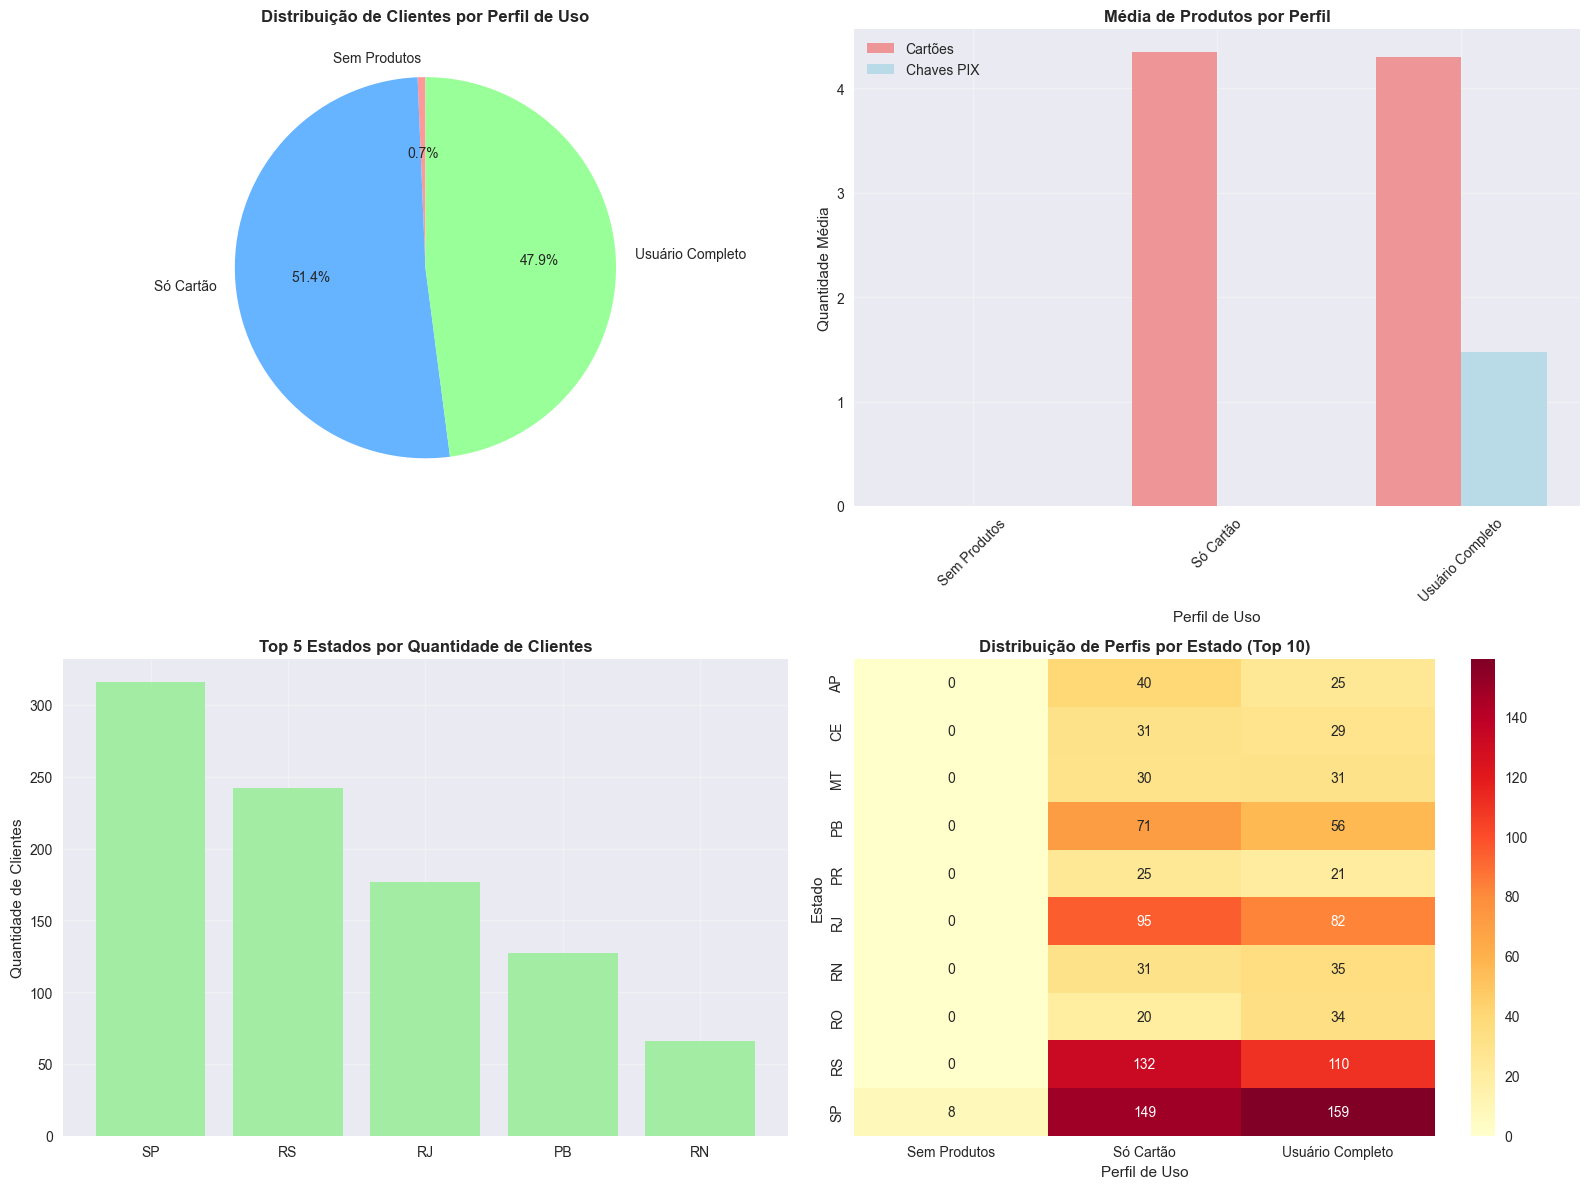


📊 Insights Principais:
• Perfil dominante: Só Cartão (51.4% dos clientes)
• Estado com mais clientes: SP (316 clientes)
• Total de clientes analisados: 1,214

✅ Análises intermediárias concluídas!
🔄 Próximo passo: Execute o notebook de análises complexas


In [ ]:
# Consulta 3: Análise de relacionamento PIX vs Cartões
query_3 = f"""
WITH cliente_produtos AS (
    SELECT 
        cl.id_cliente,
        cl.nome as nome_cliente,
        cl.cpf,
        a.estado,
        a.cidade,
        COUNT(DISTINCT cart.numero_cartao) as total_cartoes,
        COUNT(DISTINCT CASE WHEN cart.status = 'A' THEN cart.numero_cartao END) as cartoes_ativos,
        COUNT(DISTINCT pix.id_chave_pix) as total_chaves_pix,
        COUNT(DISTINCT CASE WHEN pix.status = 'A' THEN pix.id_chave_pix END) as chaves_pix_ativas,
        STRING_AGG(DISTINCT pix.tipo_chave, ', ') as tipos_chaves_pix
    FROM "{TARGET_SCHEMA}".clientes cl
    JOIN "{TARGET_SCHEMA}".contas c ON cl.id_cliente = c.id_cliente
    JOIN "{TARGET_SCHEMA}".agencias a ON c.codigo_agencia = a.codigo_agencia
    LEFT JOIN "{TARGET_SCHEMA}".cartoes cart ON cl.id_cliente = cart.id_cliente
    LEFT JOIN "{TARGET_SCHEMA}".chaves_pix pix ON c.id_conta = pix.id_conta
    GROUP BY cl.id_cliente, cl.nome, cl.cpf, a.estado, a.cidade
),
perfil_produtos AS (
    SELECT *,
        CASE 
            WHEN total_cartoes > 0 AND total_chaves_pix > 0 THEN 'Usuário Completo'
            WHEN total_cartoes > 0 AND total_chaves_pix = 0 THEN 'Só Cartão'
            WHEN total_cartoes = 0 AND total_chaves_pix > 0 THEN 'Só PIX'
            ELSE 'Sem Produtos'
        END as perfil_uso
    FROM cliente_produtos
)
SELECT 
    perfil_uso,
    estado,
    COUNT(*) as quantidade_clientes,
    AVG(total_cartoes) as media_cartoes,
    AVG(total_chaves_pix) as media_chaves_pix,
    AVG(cartoes_ativos) as media_cartoes_ativos,
    AVG(chaves_pix_ativas) as media_chaves_ativas,
    COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(PARTITION BY estado) as percentual_estado
FROM perfil_produtos
GROUP BY perfil_uso, estado
HAVING COUNT(*) > 5
ORDER BY estado, quantidade_clientes DESC;
"""

resultado_3 = pd.read_sql(query_3, engine)

print("💳 ANÁLISE DE RELACIONAMENTO PIX vs CARTÕES POR ESTADO")
print("=" * 85)
print(f"{'Estado':<6} {'Perfil':<16} {'Qtd':<6} {'% Estado':<9} {'Cartões':<8} {'PIX':<6}")
print("-" * 85)

for _, row in resultado_3.head(20).iterrows():
    print(f"{row['estado']:<6} {row['perfil_uso']:<16} "
          f"{row['quantidade_clientes']:>4} {row['percentual_estado']:>8.1f}% "
          f"{row['media_cartoes']:>7.1f} {row['media_chaves_pix']:>5.1f}")

# Análise consolidada por perfil
consolidado = resultado_3.groupby('perfil_uso').agg({
    'quantidade_clientes': 'sum',
    'media_cartoes': 'mean',
    'media_chaves_pix': 'mean'
}).reset_index()

total_clientes = consolidado['quantidade_clientes'].sum()
consolidado['percentual_total'] = (consolidado['quantidade_clientes'] / total_clientes) * 100

# Visualização
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Distribuição geral por perfil
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
wedges, texts, autotexts = ax1.pie(consolidado['quantidade_clientes'], 
                                   labels=consolidado['perfil_uso'],
                                   autopct='%1.1f%%',
                                   colors=colors,
                                   startangle=90)
ax1.set_title('Distribuição de Clientes por Perfil de Uso', fontweight='bold')

# Gráfico 2: Produtos por perfil
x_pos = range(len(consolidado))
width = 0.35

bars1 = ax2.bar([x - width/2 for x in x_pos], consolidado['media_cartoes'], 
                width, label='Cartões', color='lightcoral', alpha=0.8)
bars2 = ax2.bar([x + width/2 for x in x_pos], consolidado['media_chaves_pix'], 
                width, label='Chaves PIX', color='lightblue', alpha=0.8)

ax2.set_title('Média de Produtos por Perfil', fontweight='bold')
ax2.set_xlabel('Perfil de Uso')
ax2.set_ylabel('Quantidade Média')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(consolidado['perfil_uso'], rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Gráfico 3: Distribuição por estado (top 5)
top_estados = resultado_3.groupby('estado')['quantidade_clientes'].sum().nlargest(5)
ax3.bar(top_estados.index, top_estados.values, color='lightgreen', alpha=0.8)
ax3.set_title('Top 5 Estados por Quantidade de Clientes', fontweight='bold')
ax3.set_ylabel('Quantidade de Clientes')
ax3.grid(True, alpha=0.3)

# Gráfico 4: Heatmap de perfis por estado
pivot_estados = resultado_3.pivot_table(index='estado', 
                                        columns='perfil_uso', 
                                        values='quantidade_clientes', 
                                        fill_value=0)
sns.heatmap(pivot_estados.head(10), annot=True, fmt='.0f', cmap='YlOrRd', ax=ax4)
ax4.set_title('Distribuição de Perfis por Estado (Top 10)', fontweight='bold')
ax4.set_xlabel('Perfil de Uso')
ax4.set_ylabel('Estado')

plt.tight_layout()
plt.show()

print(f"\n📊 Insights Principais:")
perfil_dominante = consolidado.loc[consolidado['percentual_total'].idxmax()]
print(f"• Perfil dominante: {perfil_dominante['perfil_uso']} ({perfil_dominante['percentual_total']:.1f}% dos clientes)")
print(f"• Estado com mais clientes: {top_estados.index[0]} ({top_estados.iloc[0]:,} clientes)")
print(f"• Total de clientes analisados: {total_clientes:,}")

print("\n✅ Análises intermediárias concluídas!")
print("🔄 Próximo passo: Execute o notebook de análises complexas")